# Overview
In this notebook, we predict expectation ratings using brain data <br>
We use four expectation rating regression, pain/vicarious/cognitive/general
the epoch is the cue epoch modeled. 

Addition: I rescale the ratings
concern: pain, vicarious, cognitive have different intensities. the scale does not mend well. the model may be driven by pain ratings

In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import h5py

import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py

from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error

from nilearn import image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from nilearn.image import resample_to_img, math_img, new_img_like

import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nnt_data

from surfplot import Plot

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
def extract_metadata(filenames):
    pattern = re.compile(
        r"sub-(?P<sub>\d+)_"
        r"ses-(?P<ses>\d+)_"
        r"run-(?P<run>\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"trial-(?P<trial>\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimintensity>\w+)"
    )
    metadata_list = []
    for filename in filenames:
        match = pattern.search(filename)
        if match:
            metadata = match.groupdict()
            metadata_list.append(metadata)
    return pd.DataFrame(metadata_list)

In [3]:
def plot_scores(X_train_r, Y_train_r,
                X_test_r, Y_test_r):

    # 1) On diagonal plot X vs Y scores on each components
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 1")
    plt.ylabel("Y comp. 1")
    plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 2")
    plt.ylabel("Y comp. 2")
    plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    # 2) Off diagonal plot components 1 vs 2 for X and Y
    plt.subplot(222)
    plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("X comp. 1")
    plt.ylabel("X comp. 2")
    plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
              % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(223)
    plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("Y comp. 1")
    plt.ylabel("Y comp. 2")
    plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
              % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [4]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(5000, 1000), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


In [5]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces_lateralonly(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(5000, 1000), 
             zoom=1.2, layout='row', 
             views=['lateral'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


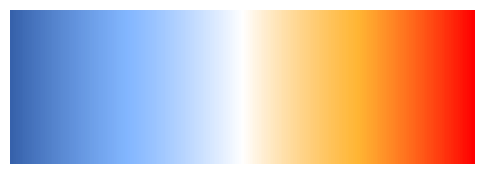

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()



# 0. load data
load the single trials parcellated files and the behavioral files of the corresponding single trials <br>
If you want to check how the single trials were generated, check the metadata attached to the brain numpy

In [7]:
current_dir = os.getcwd()
current_dir
main_dir = Path(current_dir).parents[2] 
print(main_dir)
from neuromaps.images import dlabel_to_gifti, annot_to_gifti
from neuromaps import transforms
# /Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/nilearn/deriv02_parcel-schaefer400/singletrial_rampupplateau_task-pvc_atlas-schaefer2018.npy'
brain_glasser = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-glasser', 'singletrial_rampupplateau_task-pvc_epoch-cue_atlas-glasser.npy'))

brain_subcortexdf = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-canlab2023subcortex', 'singletrial_rampupplateau_task-pvc_epoch-cue_atlas-canlab2023subcortex.npy'))

print(f"Shape of the glasser parcel data {brain_glasser.shape}")
print(f"Shape of the subcortex data {brain_subcortexdf.shape}")
df_glasser = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-glasser', 
                                  'singletrial_rampupplateau_task-pvc_epoch-cue_atlas-glasser.tsv'), sep='\t')
df_glasser_subcortex = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-canlab2023subcortex', 
                                  'singletrial_rampupplateau_task-pvc_epoch-cue_atlas-canlab2023subcortex.tsv'), sep='\t')
hcplh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/lh.HCP-MMP1.annot')
hcprh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/rh.HCP-MMP1.annot')
HCP_fslr_lh = transforms.fsaverage_to_fslr(hcplh, hemi='L', target_density='32k', method='nearest')
HCP_fslr_rh = transforms.fsaverage_to_fslr(hcprh, hemi='R', target_density='32k', method='nearest')
HCP_fslr_rh_update = HCP_fslr_rh
HCP_fslr_rh_update[0].darrays[0].data = np.where(HCP_fslr_rh[0].agg_data() != 0, HCP_fslr_rh[0].agg_data() + 180, HCP_fslr_rh[0].agg_data())
hcp_glasser = (HCP_fslr_lh[0], HCP_fslr_rh_update[0])

# %% apply parcellation
canlab2023 = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin6Asym_coarse_2mm_cifti_vols.nii.gz'

HCPparc = Parcellater(hcp_glasser, 'fsLR', resampling_target='parcellation')
subcortexparc = Parcellater(parcellation=canlab2023, 
                       space='MNI152', 
                       resampling_target='parcellation')
# schaefer = nnt_data.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
# parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')

df_beh = pd.read_csv('/Users/h/Documents/projects_local/cue_expectancy/data/beh/sub-all_task-all_events.tsv', sep='\t')

/Users/h/Documents/projects_local/cue_expectancy
Shape of the glasser parcel data (17206, 360)
Shape of the subcortex data (17206, 166)


In [8]:
df_beh['singletrial_fname'][0]

'sub-0002_ses-03_run-01_runtype-vicarious_event-stimulus_trial-000_cuetype-low_stimintensity-low.nii.gz'

In [9]:
df_glasser['singletrial_fname'][0]

'sub-0002_ses-03_run-01_runtype-vicarious_event-cue_trial-001_cuetype-high.nii.gz'

## 0-1. merge behavioral and single trial data

In [10]:
# Adjusting the function to include prefixes for sub, ses, and run in the output
def parse_filename_with_regex_adjusted(filename):
    # Updated regular expression pattern to keep the prefixes in the extracted values
    pattern = r"(sub-\d+)_(ses-\d+)_(run-\d+)_runtype-(\w+)_event-(\w+)_trial-(\d+)_cuetype-(\w+).nii.gz"
    match = re.match(pattern, filename)
    
    if match:
        metadata = {
            'sub': match.group(1),  # Keeping the prefix for sub
            'ses':  match.group(2),  # Adding 'ses-' prefix
            'run':  match.group(3),  # Adding 'run-' prefix
            'runtype': match.group(4),
            'event': match.group(5),
            'trial_index': int(match.group(6)),  # Convert trial_index to integer
            'cue': match.group(7) + '_cue',  # Append "_cue" to cue value
            # 'stimulusintensity': match.group(8) + '_stim',  # Append "_stim" to stimulusintensity value
        }
        return metadata
    else:
        return {}

# Test the adjusted function with the sample filename
df_parsed = (df_glasser['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
df_glasser = pd.concat([df_glasser['singletrial_fname'], df_parsed], axis=1)

df_parsed_subcortex = (df_glasser_subcortex['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
df_subcortex = pd.concat([df_glasser_subcortex['singletrial_fname'], df_parsed_subcortex], axis=1)


brain_metadf = pd.merge(df_glasser, df_subcortex, on=["singletrial_fname", "sub", "ses", "run", "runtype", "event", "trial_index", "cue"], how="inner")


In [11]:
brain_metadf

singletrial_fname       sub     ses  \
0      sub-0002_ses-03_run-01_runtype-vicarious_event...  sub-0002  ses-03   
1      sub-0002_ses-03_run-03_runtype-cognitive_event...  sub-0002  ses-03   
2      sub-0002_ses-03_run-02_runtype-pain_event-cue_...  sub-0002  ses-03   
3      sub-0002_ses-03_run-01_runtype-vicarious_event...  sub-0002  ses-03   
4      sub-0002_ses-03_run-05_runtype-vicarious_event...  sub-0002  ses-03   
...                                                  ...       ...     ...   
17201  sub-0133_ses-03_run-01_runtype-pain_event-cue_...  sub-0133  ses-03   
17202  sub-0133_ses-03_run-01_runtype-pain_event-cue_...  sub-0133  ses-03   
17203  sub-0133_ses-04_run-02_runtype-pain_event-cue_...  sub-0133  ses-04   
17204  sub-0133_ses-01_run-01_runtype-cognitive_event...  sub-0133  ses-01   
17205  sub-0133_ses-04_run-02_runtype-pain_event-cue_...  sub-0133  ses-04   

          run    runtype event  trial_index       cue  
0      run-01  vicarious   cue            1  high_cue  
1      run-03  cognitive   cue            4  high_cue  
2      run-02       pain   cue            6  high_cue  
3      run-01  vicarious   cue            0   low_cue  
4      run-05  vicarious   cue           11   low_cue  
...       ...        ...   ...          ...       ...  
17201  run-01       pain   cue            3  high_cue  
17202  run-01       pain   cue           10  high_cue  
17203  run-02       pain   cue            5   low_cue  
17204  run-01  cognitive   cue           11   low_cue  
17205  run-02       pain   cue           10  high_cue  

[17206 rows x 8 columns]

In [12]:
def parse_filename_with_regex_adjusted(filename):
    # Updated regular expression pattern to keep the prefixes in the extracted values
    pattern = r"(sub-\d+)_(ses-\d+)_(run-\d+)_runtype-(\w+)_event-(\w+)_trial-(\d+)_cuetype-(\w+)_([^\._]+).nii.gz"
    match = re.match(pattern, filename)
    
    if match:
        metadata = {
            'sub': match.group(1),  # Keeping the prefix for sub
            'ses':  match.group(2),  # Adding 'ses-' prefix
            'run':  match.group(3),  # Adding 'run-' prefix
            'runtype': match.group(4),
            'event': match.group(5),
            'trial_index': int(match.group(6)),  # Convert trial_index to integer
            'cue': match.group(7) + '_cue',  # Append "_cue" to cue value
            # 'stimulusintensity': match.group(8) + '_stim',  # Append "_stim" to stimulusintensity value
        }
        return metadata
    else:
        return {}

def extract_trial_index(filename):
    pattern = r"_trial-(\d+)_"
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))  # Convert trial_index to integer and return it
    else:
        return None  # Return None or an appropriate value for filenames that do not match


df_beh_removetrial= df_beh.drop('trial_index', axis=1)
df_beh_removetrial['trial_index'] = df_beh_removetrial['singletrial_fname'].apply(extract_trial_index)
df_parsed = (df_beh_removetrial['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
df_beh_removefname= df_beh_removetrial.drop('singletrial_fname', axis=1)
# df_beh_clean = pd.concat([df_beh_removefname, df_parsed], axis=1)

df_beh_modified = pd.merge(df_beh_removefname, df_parsed, on=[ "sub", "ses", "run", "runtype", "cue", "trial_index"], how="inner")
df_beh_modified['event'] = 'cue'
df_beh_modified = df_beh_modified.drop('stimulusintensity', axis=1)


In [17]:
import pandas as df

# Assuming 'df' is your pandas DataFrame with the columns 'sub', 'runtype', 'expectrating'

# Function to rescale 'expectrating' within each 'sub' and 'runtype'
def rescale_expectratings(sub_df):
    # Iterate over each runtype within the subject dataframe
    for runtype in sub_df['runtype'].unique():
        # Filter for the current runtype
        runtype_df = sub_df[sub_df['runtype'] == runtype]
        # Find the maximum 'expectrating' for the current runtype
        max_rating = runtype_df['expectrating'].max()
        # Rescale 'expectrating' to the [0, 1] range based on the max value
        sub_df.loc[sub_df['runtype'] == runtype, 'rescaled_expectrating'] = runtype_df['expectrating'] / max_rating
    return sub_df

def rescale_expectratings(sub_df):
    # Iterate over each runtype within the subject dataframe
    for runtype in sub_df['runtype'].unique():
        # Filter for the current runtype
        runtype_df = sub_df[sub_df['runtype'] == runtype]
        # Find the maximum 'expectrating' for the current runtype
        max_rating = runtype_df['expectrating'].max()
        # Rescale 'expectrating' to the [0, 1] range based on the max value
        sub_df.loc[sub_df['runtype'] == runtype, 'rescaled_expectrating'] = runtype_df['expectrating'] / max_rating
    return sub_df
# Apply the rescaling function to each subject's data
df_beh_modified = df_beh_modified.groupby('sub').apply(rescale_expectratings).reset_index(drop=True)

# Now 'df_rescaled' contains a new column 'rescaled_expectrating' with values rescaled within [0, 1] for each runtype within each subject


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_68296/2873926036.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_beh_modified = df_beh_modified.groupby('sub').apply(rescale_expectratings).reset_index(drop=True)


In [18]:
df_beh_modified.head()

sub     ses     run    runtype       cue  expectrating expectlabel  \
0  sub-0002  ses-03  run-01  vicarious   low_cue           NaN         NaN   
1  sub-0002  ses-03  run-01  vicarious  high_cue           NaN         NaN   
2  sub-0002  ses-03  run-01  vicarious  high_cue         53.37      Strong   
3  sub-0002  ses-03  run-01  vicarious  high_cue         36.87      Strong   
4  sub-0002  ses-03  run-01  vicarious   low_cue         32.25      Strong   

   outcomerating outcomelabel  trial_index event  rescaled_expectrating  
0            NaN          NaN            0   cue                    NaN  
1          32.54       Strong            1   cue                    NaN  
2           9.46         Weak            2   cue               0.562856  
3          46.95       Strong            3   cue               0.388842  
4          63.22       Strong            4   cue               0.340118

In [19]:
braindf = np.hstack([brain_glasser, brain_subcortexdf]) # merge brain numpys
brain_metadf['index'] = brain_metadf.index
merged_df = pd.merge(brain_metadf, df_beh_modified, on=[ "sub", "ses", "run", "runtype", "event","cue",  "trial_index"], how="inner")
print(merged_df.shape)
merged_df.head()


(17206, 14)


singletrial_fname       sub     ses  \
0  sub-0002_ses-03_run-01_runtype-vicarious_event...  sub-0002  ses-03   
1  sub-0002_ses-03_run-03_runtype-cognitive_event...  sub-0002  ses-03   
2  sub-0002_ses-03_run-02_runtype-pain_event-cue_...  sub-0002  ses-03   
3  sub-0002_ses-03_run-01_runtype-vicarious_event...  sub-0002  ses-03   
4  sub-0002_ses-03_run-05_runtype-vicarious_event...  sub-0002  ses-03   

      run    runtype event  trial_index       cue  index  expectrating  \
0  run-01  vicarious   cue            1  high_cue      0           NaN   
1  run-03  cognitive   cue            4  high_cue      1           NaN   
2  run-02       pain   cue            6  high_cue      2        111.37   
3  run-01  vicarious   cue            0   low_cue      3           NaN   
4  run-05  vicarious   cue           11   low_cue      4           NaN   

                       expectlabel  outcomerating       outcomelabel  \
0                              NaN          32.54             Strong   
1                              NaN           1.68  Barely detectable   
2  Strongest sensation of any kind          70.24        Very Strong   
3                              NaN            NaN                NaN   
4                              NaN            NaN                NaN   

   rescaled_expectrating  
0                    NaN  
1                    NaN  
2               0.862464  
3                    NaN  
4                    NaN

In [14]:
braindf[merged_df.index.tolist()].shape

(17206, 526)

In [20]:
# make sure the beh+NPS data is in the parcel data


cleanbraindf = braindf[merged_df.index.tolist()]
print(f"brain df shape: {cleanbraindf.shape}")
print(f"behavioral - brain intersection shape: {merged_df.shape}")


brain df shape: (17206, 526)
behavioral - brain intersection shape: (17206, 14)


## 0-2. plot behavioral data

We're going to grab a subset of regressors. Here's just a demo of the regressors we can grab.
It has 
* 1) stimulus, inserted as a contrast code,
* 2) expectation rating, not yet z scored
* 3) outcome rating, not yet z scored.


In [21]:
# merged_df['stim_con'] = merged_df['stimulusintensity'].replace({'high_stim':1, 
#                                            'med_stim':0, 
#                                            'low_stim':-1})
merged_df['cue_con'] = merged_df['cue'].replace({'high_cue':1, 
                                           'low_cue':-1})   
cleanbehdf = merged_df
print(f"column names: {merged_df.columns}")
print(f"take a look at the beh + NPS dataframe: {merged_df.head()}")


column names: Index(['singletrial_fname', 'sub', 'ses', 'run', 'runtype', 'event',
       'trial_index', 'cue', 'index', 'expectrating', 'expectlabel',
       'outcomerating', 'outcomelabel', 'rescaled_expectrating', 'cue_con'],
      dtype='object')
take a look at the beh + NPS dataframe:                                    singletrial_fname       sub     ses  \
0  sub-0002_ses-03_run-01_runtype-vicarious_event...  sub-0002  ses-03   
1  sub-0002_ses-03_run-03_runtype-cognitive_event...  sub-0002  ses-03   
2  sub-0002_ses-03_run-02_runtype-pain_event-cue_...  sub-0002  ses-03   
3  sub-0002_ses-03_run-01_runtype-vicarious_event...  sub-0002  ses-03   
4  sub-0002_ses-03_run-05_runtype-vicarious_event...  sub-0002  ses-03   

      run    runtype event  trial_index       cue  index  expectrating  \
0  run-01  vicarious   cue            1  high_cue      0           NaN   
1  run-03  cognitive   cue            4  high_cue      1           NaN   
2  run-02       pain   cue            6  h

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_68296/3457823119.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['cue_con'] = merged_df['cue'].replace({'high_cue':1,


In [22]:
dummy_vars = pd.get_dummies(cleanbehdf['runtype'])
beh = pd.concat([cleanbehdf, dummy_vars], axis=1)
beh.rename(columns={'pain': 'dummy_pain', 'vicarious': 'dummy_vicarious', 'cognitive': 'dummy_cognitive'}, inplace=True)
beh['dummy_general'] = 1 # adding domain general regressor
beh['pain_expect'] = beh['dummy_pain'] * beh['rescaled_expectrating']
beh['vic_expect'] = beh['dummy_vicarious'] * beh['rescaled_expectrating']
beh['cog_expect'] = beh['dummy_cognitive'] * beh['rescaled_expectrating']
beh['gen_expect'] = beh['dummy_general'] * beh['rescaled_expectrating']


singletrial = cleanbraindf  # zscored_braindf  # np.random.randn(89, 1)      # Replace with your actual data
# identify groups
from collections import Counter

# subject_ids = [int(re.search(r"sub-(\d+)", fname).group(1)) for fname in flist]
subject_counts = Counter(beh['sub'])  # Count the occurrences of each subject
factorized_ids, unique_ids = pd.factorize(beh['sub'])
groupsinterim = (
    factorized_ids + 1
) 

print(f"beh: {beh.shape} ")
print(f"Y: {singletrial.shape} ")
print(f"groups: {groupsinterim.shape} ")


# Create a dataframe for keep tracking the group ids and bids id _______________
df_mapping = pd.DataFrame({
    "group_id": range(1, len(unique_ids) + 1),
    "bids_id": unique_ids
})

df_mapping.head()



beh: (17206, 23) 
Y: (17206, 526) 
groups: (17206,) 


group_id   bids_id
0         1  sub-0002
1         2  sub-0005
2         3  sub-0013
3         4  sub-0014
4         5  sub-0015

In [23]:
cleanbraindf

array([[-9.2081604 , -2.4858067 , -6.27876186, ..., -2.02906127,
        -1.07087526, -1.7261529 ],
       [-0.95253867,  0.81118441, -1.02560377, ...,  0.41122757,
         0.22379261,  0.29556221],
       [-1.89053428, -0.93824601, -3.26097202, ...,  0.80277295,
         3.77107866,  1.73024135],
       ...,
       [ 4.86587143,  3.78385377,  5.11773443, ...,  6.41680921,
         1.44302579,  1.14813619],
       [ 0.83966672, -0.74450064,  2.1070106 , ...,  0.09825643,
         1.89163515, -0.14361455],
       [ 5.23553896,  1.86987817,  2.94647384, ..., -1.31992595,
         0.89294266,  2.47522324]])

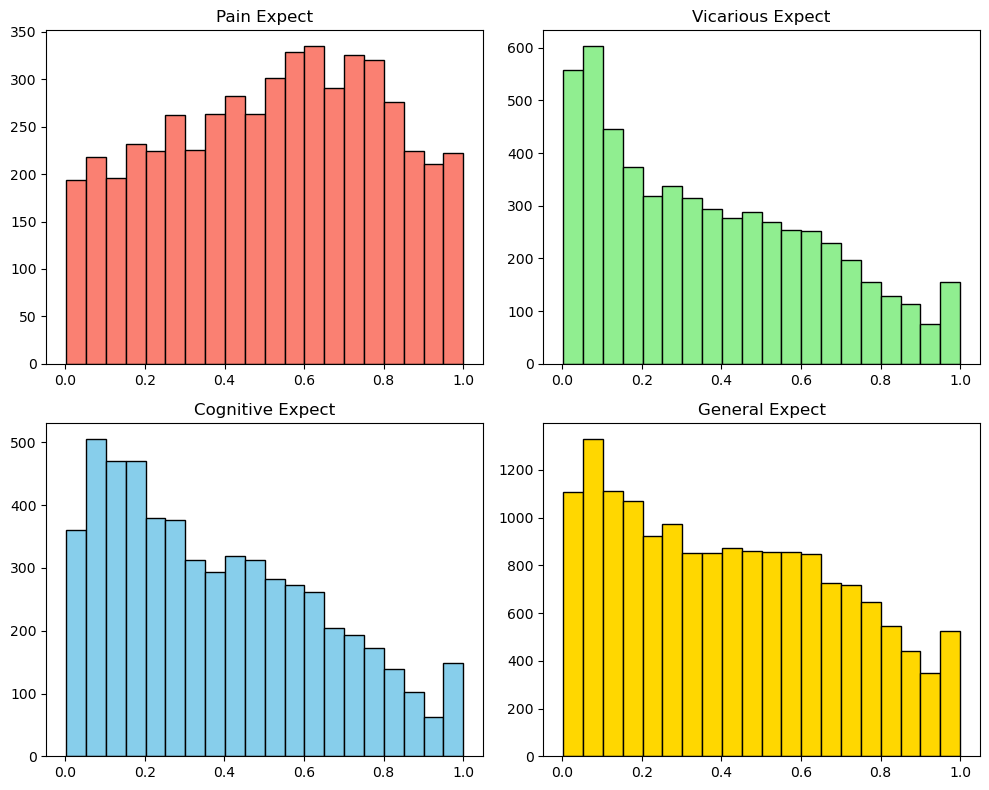

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid, adjust size as needed

# Plotting the distributions
axs[0, 0].hist(beh['pain_expect'][beh['pain_expect'] != 0], bins=20, color='salmon', edgecolor='black')
axs[0, 0].set_title('Pain Expect')

axs[0, 1].hist(beh['vic_expect'][beh['vic_expect'] != 0], bins=20, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Vicarious Expect')

axs[1, 0].hist(beh['cog_expect'][beh['cog_expect'] != 0], bins=20, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Cognitive Expect')

axs[1, 1].hist(beh['gen_expect'][beh['gen_expect'] != 0], bins=20, color='gold', edgecolor='black')
axs[1, 1].set_title('General Expect')

# Adjusting layout
plt.tight_layout()

# Show the plots
plt.show()

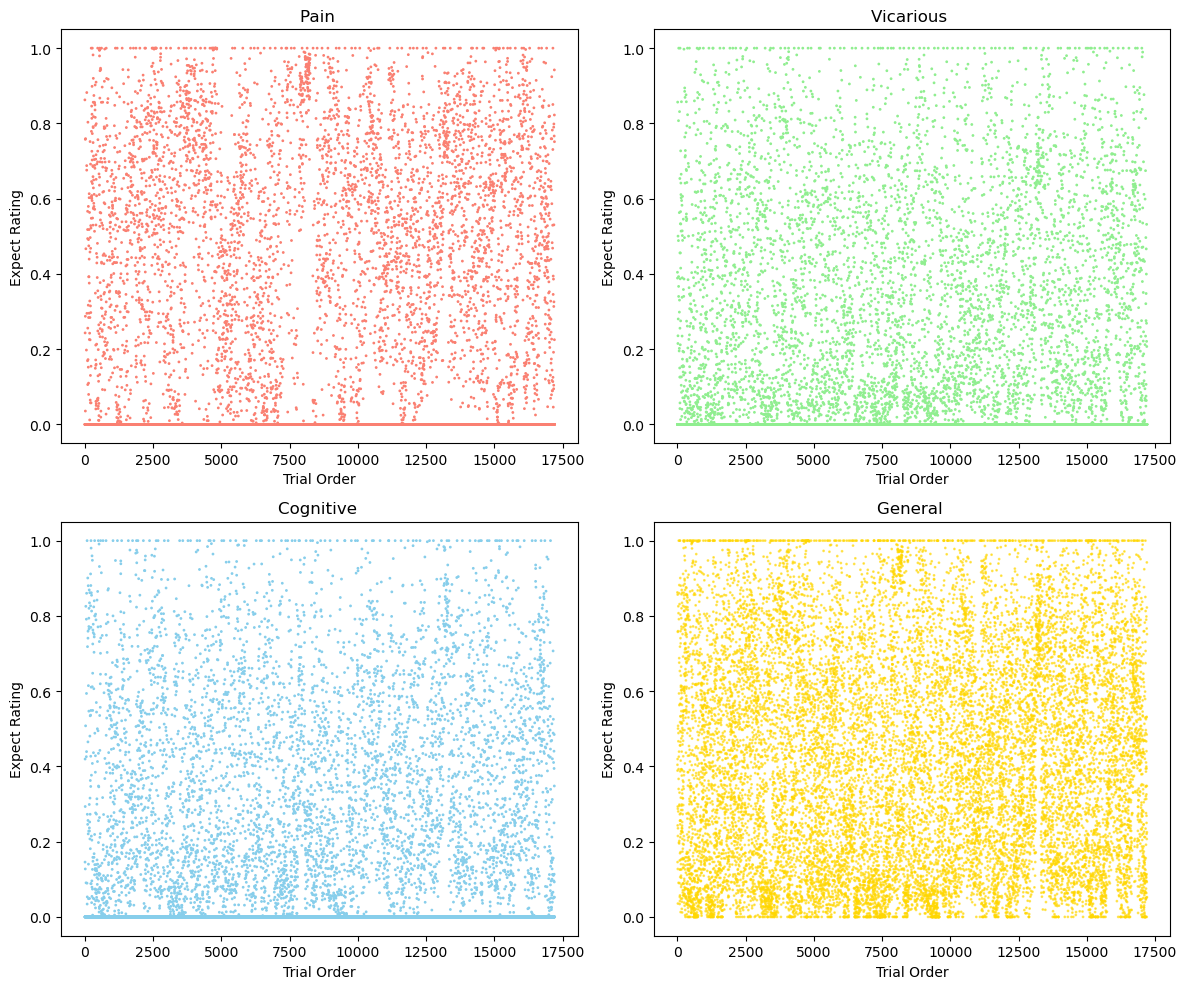

In [25]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid, adjust size as needed

# Plotting the outcomes across trials
axs[0, 0].scatter(beh.index, beh['pain_expect'], s=1, marker='o', linestyle='', color='salmon')
axs[0, 0].set_title('Pain ')
axs[0, 0].set_xlabel('Trial Order')
axs[0, 0].set_ylabel('Expect Rating')

axs[0, 1].scatter(beh.index, beh['vic_expect'], s=1, marker='o', linestyle='', color='lightgreen')
axs[0, 1].set_title('Vicarious ')
axs[0, 1].set_xlabel('Trial Order')
axs[0, 1].set_ylabel('Expect Rating')

axs[1, 0].scatter(beh.index, beh['cog_expect'], s=1, marker='o', linestyle='', color='skyblue')
axs[1, 0].set_title('Cognitive ')
axs[1, 0].set_xlabel('Trial Order')
axs[1, 0].set_ylabel('Expect Rating')

axs[1, 1].scatter(beh.index, beh['gen_expect'], s=1, marker='o', linestyle='', color='gold', alpha=0.6)
axs[1, 1].set_title('General ')
axs[1, 1].set_xlabel('Trial Order')
axs[1, 1].set_ylabel('Expect Rating')

# Adjusting layout
plt.tight_layout()

# Show the plots
plt.show()


## 0-3. incase we want to drop rows with NA
but based on https://learnche.org/pid/latent-variable-modelling/principal-component-analysis/preprocessing-the-data-before-building-a-model
for the initial analysis, include everything.

The general rule is: add as many columns into 
 as possible for the initial analysis. You can always prune out the columns later on if they are shown to be uninformative.

 The course of action when removing outliers is to always mark their values as missing just for that variable in 
, rather than removing the entire row in 
. We do this because we can use the algorithms to calculate the latent variable model when missing data are present within a row.

In [26]:
# remove nan values from X, Y, groups
import pandas as pd

# Assuming df_main is your primary DataFrame
nan_rows = beh[beh[['pain_expect', 'vic_expect', 'cog_expect', 'gen_expect']].isnull().any(axis=1)]
beh_dropna = beh.dropna()

singletrial_dropna= singletrial[beh_dropna.index.to_numpy()]
groups_dropna = groupsinterim[beh_dropna.index.to_numpy()]


In [27]:
print(f"X: {beh.shape} after dropping -> {beh_dropna.shape}")
print(f"Y: {singletrial.shape} after dropping -> {singletrial_dropna.shape}")
print(f"groups: {groupsinterim.shape} after dropping -> {groups_dropna.shape}")

X: (17206, 23) after dropping -> (16055, 23)
Y: (17206, 526) after dropping -> (16055, 526)
groups: (17206,) after dropping -> (16055,)


In [33]:
beh_dropna

singletrial_fname       sub     ses  \
2      sub-0002_ses-03_run-02_runtype-pain_event-cue_...  sub-0002  ses-03   
7      sub-0002_ses-03_run-01_runtype-vicarious_event...  sub-0002  ses-03   
8      sub-0002_ses-04_run-02_runtype-cognitive_event...  sub-0002  ses-04   
10     sub-0002_ses-03_run-03_runtype-cognitive_event...  sub-0002  ses-03   
11     sub-0002_ses-03_run-02_runtype-pain_event-cue_...  sub-0002  ses-03   
...                                                  ...       ...     ...   
17201  sub-0133_ses-03_run-01_runtype-pain_event-cue_...  sub-0133  ses-03   
17202  sub-0133_ses-03_run-01_runtype-pain_event-cue_...  sub-0133  ses-03   
17203  sub-0133_ses-04_run-02_runtype-pain_event-cue_...  sub-0133  ses-04   
17204  sub-0133_ses-01_run-01_runtype-cognitive_event...  sub-0133  ses-01   
17205  sub-0133_ses-04_run-02_runtype-pain_event-cue_...  sub-0133  ses-04   

          run    runtype event  trial_index       cue  index  expectrating  \
2      run-02       pain   cue            6  high_cue      2        111.37   
7      run-01  vicarious   cue            3  high_cue      7         36.87   
8      run-02  cognitive   cue            4  high_cue      8         13.75   
10     run-03  cognitive   cue            5  high_cue     10         39.60   
11     run-02       pain   cue           10   low_cue     11         31.40   
...       ...        ...   ...          ...       ...    ...           ...   
17201  run-01       pain   cue            3  high_cue  17201         94.13   
17202  run-01       pain   cue           10  high_cue  17202         82.16   
17203  run-02       pain   cue            5   low_cue  17203         22.49   
17204  run-01  cognitive   cue           11   low_cue  17204          4.43   
17205  run-02       pain   cue           10  high_cue  17205         75.07   

       ... rescaled_expectrating  cue_con dummy_cognitive  dummy_pain  \
2      ...              0.862464        1           False        True   
7      ...              0.388842        1           False       False   
8      ...              0.145688        1            True       False   
10     ...              0.419580        1            True       False   
11     ...              0.243166       -1           False        True   
...    ...                   ...      ...             ...         ...   
17201  ...              0.942148        1           False        True   
17202  ...              0.822340        1           False        True   
17203  ...              0.225103       -1           False        True   
17204  ...              0.052470       -1            True       False   
17205  ...              0.751376        1           False        True   

       dummy_vicarious  dummy_general  pain_expect  vic_expect  cog_expect  \
2                False              1     0.862464    0.000000    0.000000   
7                 True              1     0.000000    0.388842    0.000000   
8                False              1     0.000000    0.000000    0.145688   
10               False              1     0.000000    0.000000    0.419580   
11               False              1     0.243166    0.000000    0.000000   
...                ...            ...          ...         ...         ...   
17201            False              1     0.942148    0.000000    0.000000   
17202            False              1     0.822340    0.000000    0.000000   
17203            False              1     0.225103    0.000000    0.000000   
17204            False              1     0.000000    0.000000    0.052470   
17205            False              1     0.751376    0.000000    0.000000   

       gen_expect  
2        0.862464  
7        0.388842  
8        0.145688  
10       0.419580  
11       0.243166  
...           ...  
17201    0.942148  
17202    0.822340  
17203    0.225103  
17204    0.052470  
17205    0.751376  

[16055 rows x 23 columns]

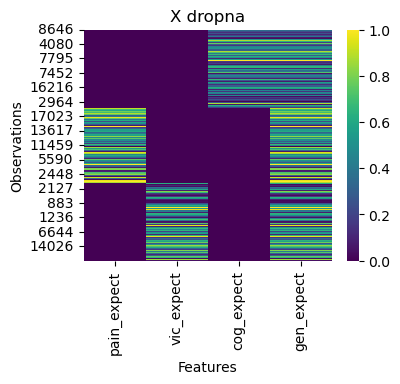

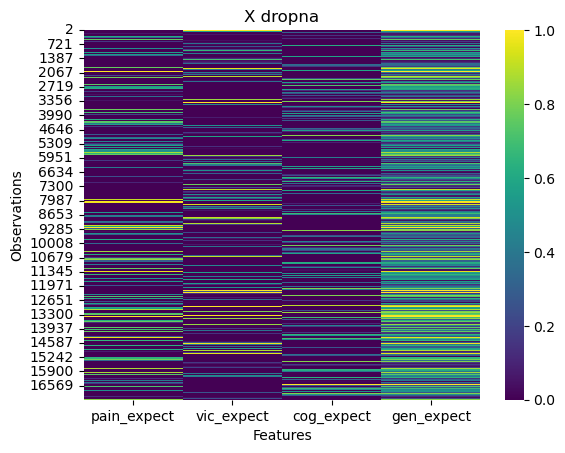

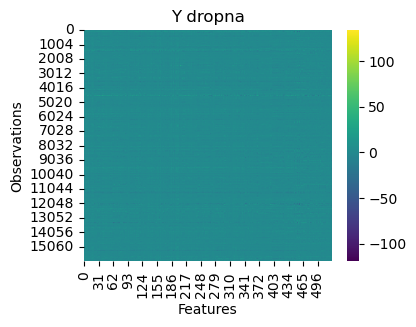

In [35]:

# Plotting
plt.figure(figsize=(4,3))
# beh_sorted = beh_dropna.sort_values(by='runtype')

sns.heatmap(beh_dropna.sort_values(by='runtype')[['pain_expect', 'vic_expect', 'cog_expect', 'gen_expect']], cmap="viridis", cbar=True)
plt.title("X dropna")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

sns.heatmap(beh_dropna[['pain_expect', 'vic_expect', 'cog_expect', 'gen_expect']], cmap="viridis", cbar=True)
plt.title("X dropna")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

plt.figure(figsize=(4,3))
sns.heatmap(singletrial_dropna, cmap="viridis", cbar=True)
plt.title("Y dropna")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


In [36]:
singletrial_dropna.shape

(16055, 526)

# 1 PLS regression

In [37]:
beh_dropna.columns

Index(['singletrial_fname', 'sub', 'ses', 'run', 'runtype', 'event',
       'trial_index', 'cue', 'index', 'expectrating', 'expectlabel',
       'outcomerating', 'outcomelabel', 'rescaled_expectrating', 'cue_con',
       'dummy_cognitive', 'dummy_pain', 'dummy_vicarious', 'dummy_general',
       'pain_expect', 'vic_expect', 'cog_expect', 'gen_expect'],
      dtype='object')

In [38]:
beh_dropna['singletrial_fname'][2]

'sub-0002_ses-03_run-02_runtype-pain_event-cue_trial-006_cuetype-high.nii.gz'

In [39]:
np.unique(groups_dropna)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [40]:
def get_bids_id_from_group_id(dataframe, group_id):
    # Filter the DataFrame for the given group_id
    filtered_df = dataframe[dataframe['group_id'] == group_id]
    
    # Check if there's at least one match
    if not filtered_df.empty:
        # Assuming group_id is unique, there should be only one matching row
        return filtered_df['bids_id'].iloc[0]
    else:
        return None  # Or any suitable value indicating the group_id does not exist


In [61]:
from sklearn.model_selection import GroupKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Assuming X, Y, and groups are already defined ________________________________
X = singletrial_dropna # (trials x Brain either voxels or parcels)
Y = beh_dropna[['pain_expect', 'vic_expect', 'cog_expect', 'gen_expect']] #(trials x ratings)
groups = groups_dropna

n_components_range = range(9, 10)  # Adjust the range as needed
outer_cv = GroupKFold(n_splits=10)
results_df = pd.DataFrame(columns=['Fold', 'Component','SubjectID', 'groupIDSubject', 'MSE', 'R2', 
                                   'Y_pred_subj','Y_test_subj','x_weights', 'x_loadings','y_weights',
                                    'y_loadings','Intercept', 'Coef'])
n_components = 10
scaler = StandardScaler()

# Main loop for GroupKFold splits ______________________________________________
model_coefs = [];   model_intercept = []
y_preds = [];   y_tests = []
bids_ids = [];  y_preds_fold = [];  mse_fold = [];r2_fold = []
beta_per_fold = []
test_ind = [];  test_indices = [];  test_ids = []
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):

    print(f"________________________________ fold {fold} ________________________________")
    print(
        f"train participants: {np.unique(groups[train_idx])},test participants: {np.unique(groups[test_idx])}, "
    )
    fold_model_coefs = [] # per fold, save the model from 90 train participants
    fold_model_intercept = []

    # Split data into training and test sets ___________________________________
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y.iloc[train_idx].to_numpy(), Y.iloc[test_idx].to_numpy()
    groups_train = groups[train_idx]
    groups_test = groups[test_idx]
    print(f"{X_train.shape} {Y_train.shape} {X_test.shape} {Y_test.shape} ")

    # build model per subject __________________________________________________

    for subject in np.unique(groups_train).tolist(): #groups_test.unique():
        # Select data for the current subject
        subject_idx = groups_train[groups_train == subject]
        subject_mask = (groups_train == subject)
        # print(np.unique(subject_idx)[0])
        bids_id = get_bids_id_from_group_id(df_mapping, np.unique(subject_idx)[0])
        print(f"{np.unique(subject_idx)[0]}: {bids_id}")
        bids_ids.append(bids_id)
        X_train_subj = X_train[subject_mask]
        Y_train_subj = Y_train[subject_mask]

        pls_subj = PLSRegression(n_components=n_components)
        pls_subj.fit(X_train_subj, Y_train_subj)

        fold_model_coefs.append(pls_subj.coef_)
        fold_model_intercept.append(pls_subj.intercept_)


    # get X tests and Y tests
    print({len(fold_model_coefs)}, {len(fold_model_intercept)}, {len(y_preds)})

    # average the model per fold _______________________________________________
    mean_coef = np.mean(np.stack(fold_model_coefs),axis=0)
    mean_int = np.mean(fold_model_intercept, axis=0)
    print(f"fold average coef, intercept shape: {mean_coef.shape}, {mean_int.shape}")


    # calculate model performance_______________________________________________
    # Here, we calculate Yprd, MSE, R2 per fold. 
    Y_pred_fold = np.dot(X_test, mean_coef) + mean_int
    print(f"y pred shape: {Y_pred_fold.shape}")
    mse_fold.append(mean_squared_error(Y_test, Y_pred_fold))
    r2_fold.append(r2_score(Y_test, Y_pred_fold))
    y_preds.append(Y_pred_fold)
    y_tests.append(Y_test)
    test_ids.append(np.array(groups_test))
    test_indices.append(test_idx)
    print(f"{mse_fold}, \n{r2_fold}")

    XTX_inv = np.linalg.inv(X_test.T.dot(X_test))
    XTY = X_test.T.dot(Y_pred_fold)#Y_pred_fold)
    beta = XTX_inv.dot(XTY)
    beta_per_fold.append(beta)



________________________________ fold 0 ________________________________
train participants: [  1   2   3   4   5   6   7   9  10  11  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  40  41  42  43  44  45  46  47  48  49  51  52  53  54  55  56  58  60
  61  62  63  64  66  67  68  69  70  72  73  74  75  77  78  79  80  81
  82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98  99 100
 101],test participants: [ 8 12 37 50 57 59 65 71 76 90], 
(14450, 526) (14450, 4) (1605, 526) (1605, 4) 
1: sub-0002
2: sub-0005
3: sub-0013
4: sub-0014
5: sub-0015
6: sub-0016
7: sub-0017
9: sub-0019
10: sub-0021
11: sub-0023
13: sub-0025
14: sub-0026
15: sub-0028
16: sub-0029
17: sub-0030
18: sub-0031
19: sub-0032
20: sub-0033
21: sub-0035
22: sub-0036
23: sub-0037
24: sub-0038
25: sub-0039
26: sub-0040
27: sub-0041
28: sub-0043
29: sub-0044
30: sub-0047
31: sub-0050
32: sub-0051
33: sub-0052
34: sub-0053
35: sub-0055
36: sub-0056
38

In [43]:
mean_coef.shape

(526, 4)

# 2 visualize results

## 2-1. beta maps

In [46]:
mean_coef.shape

(526, 4)

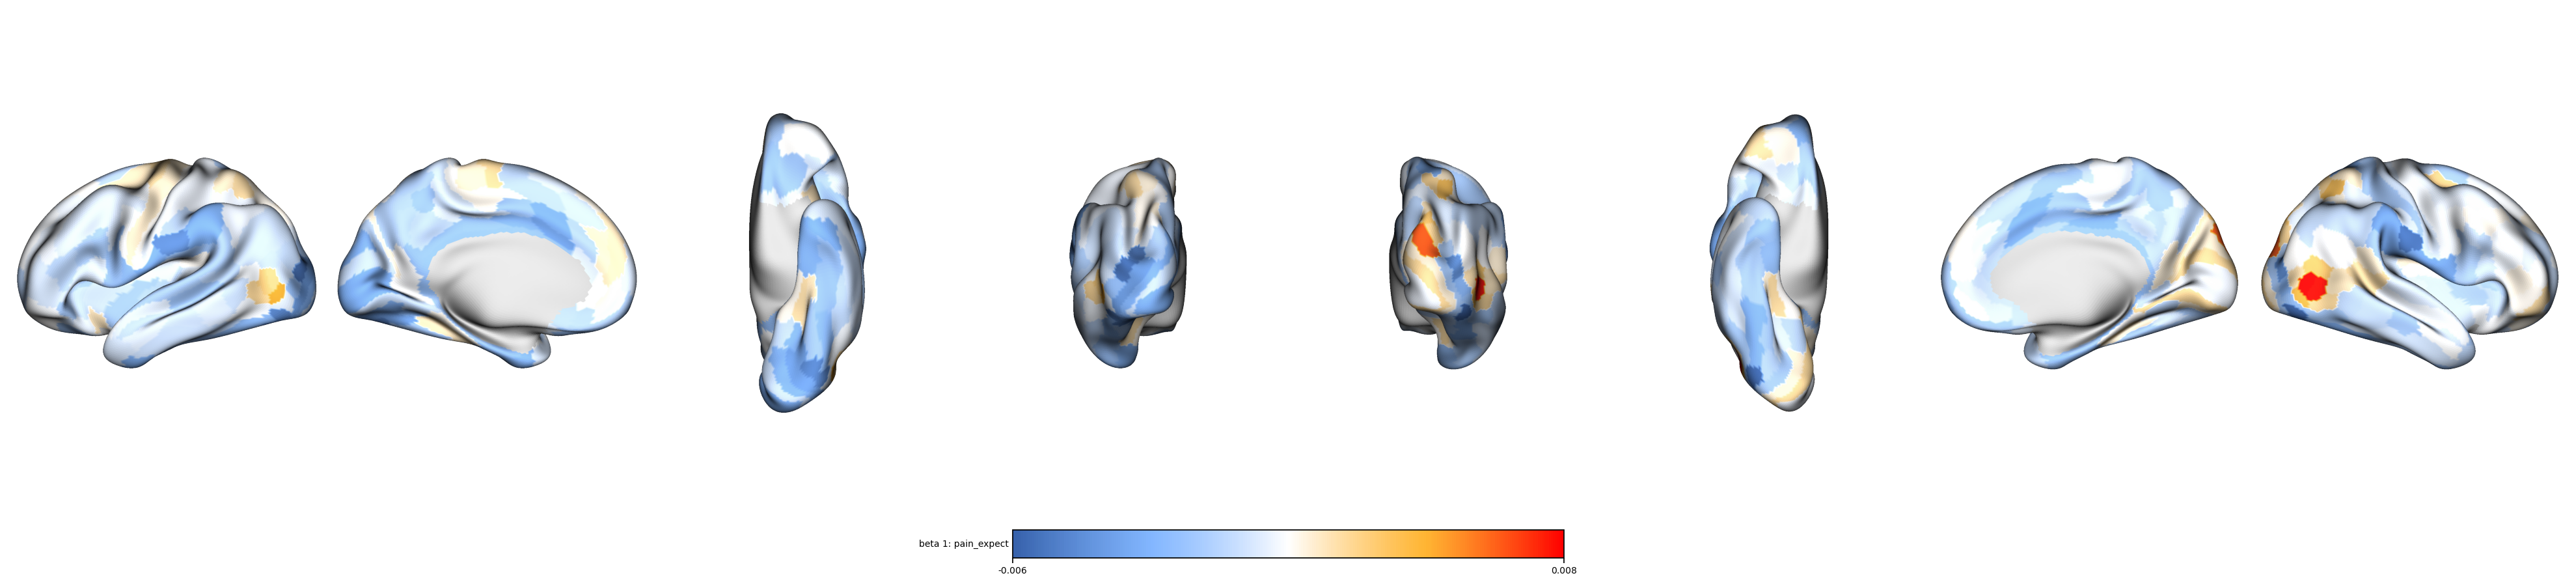

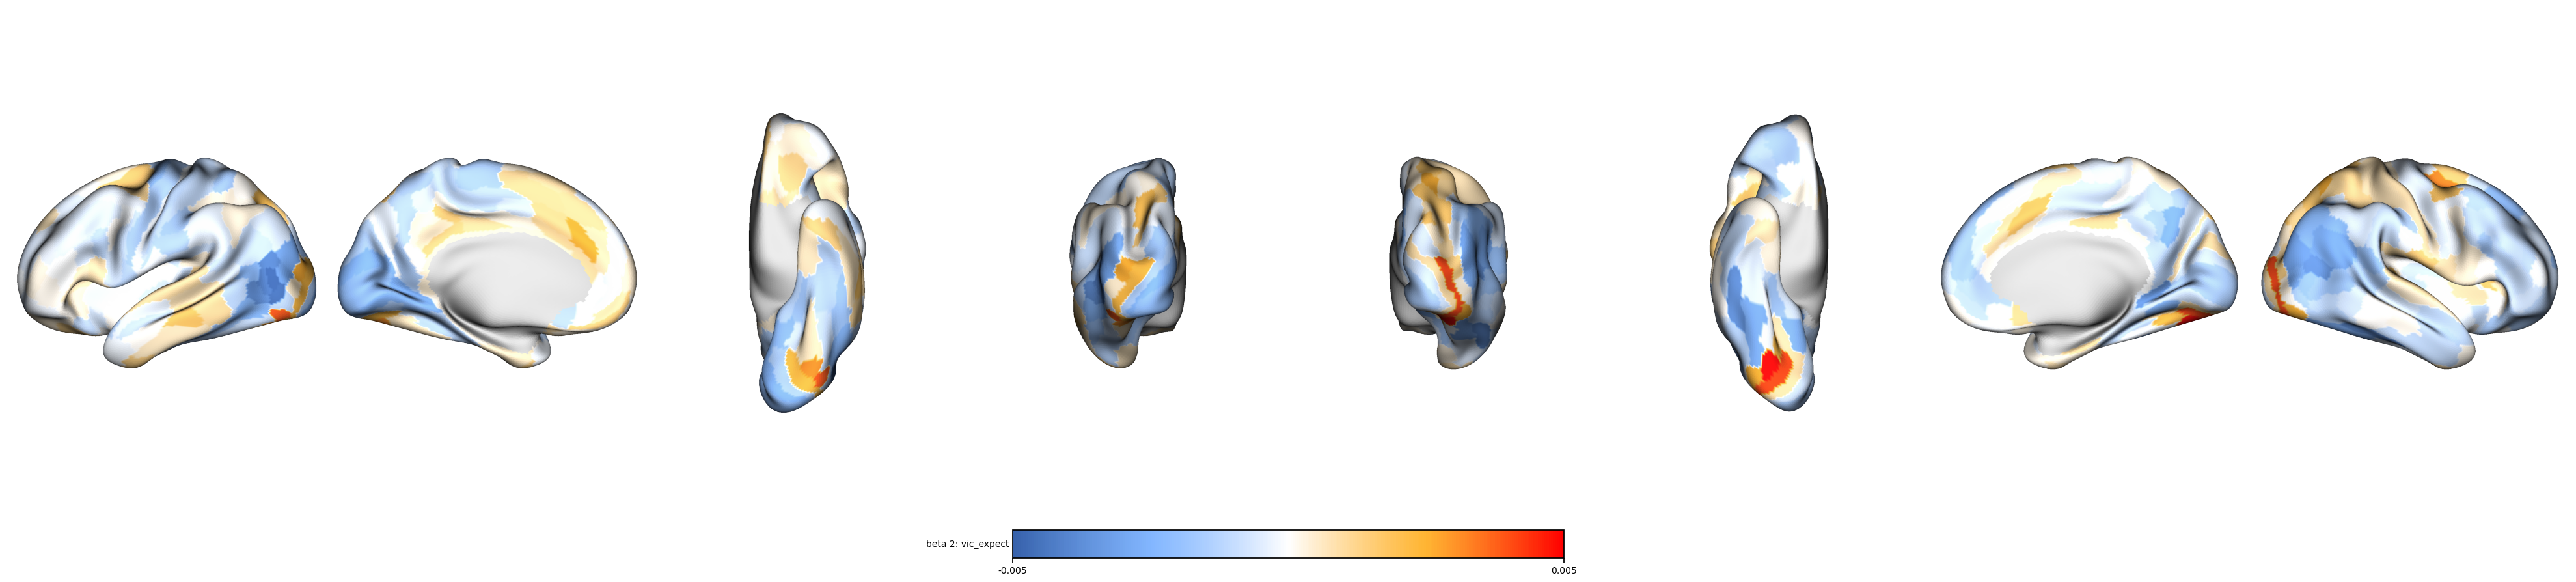

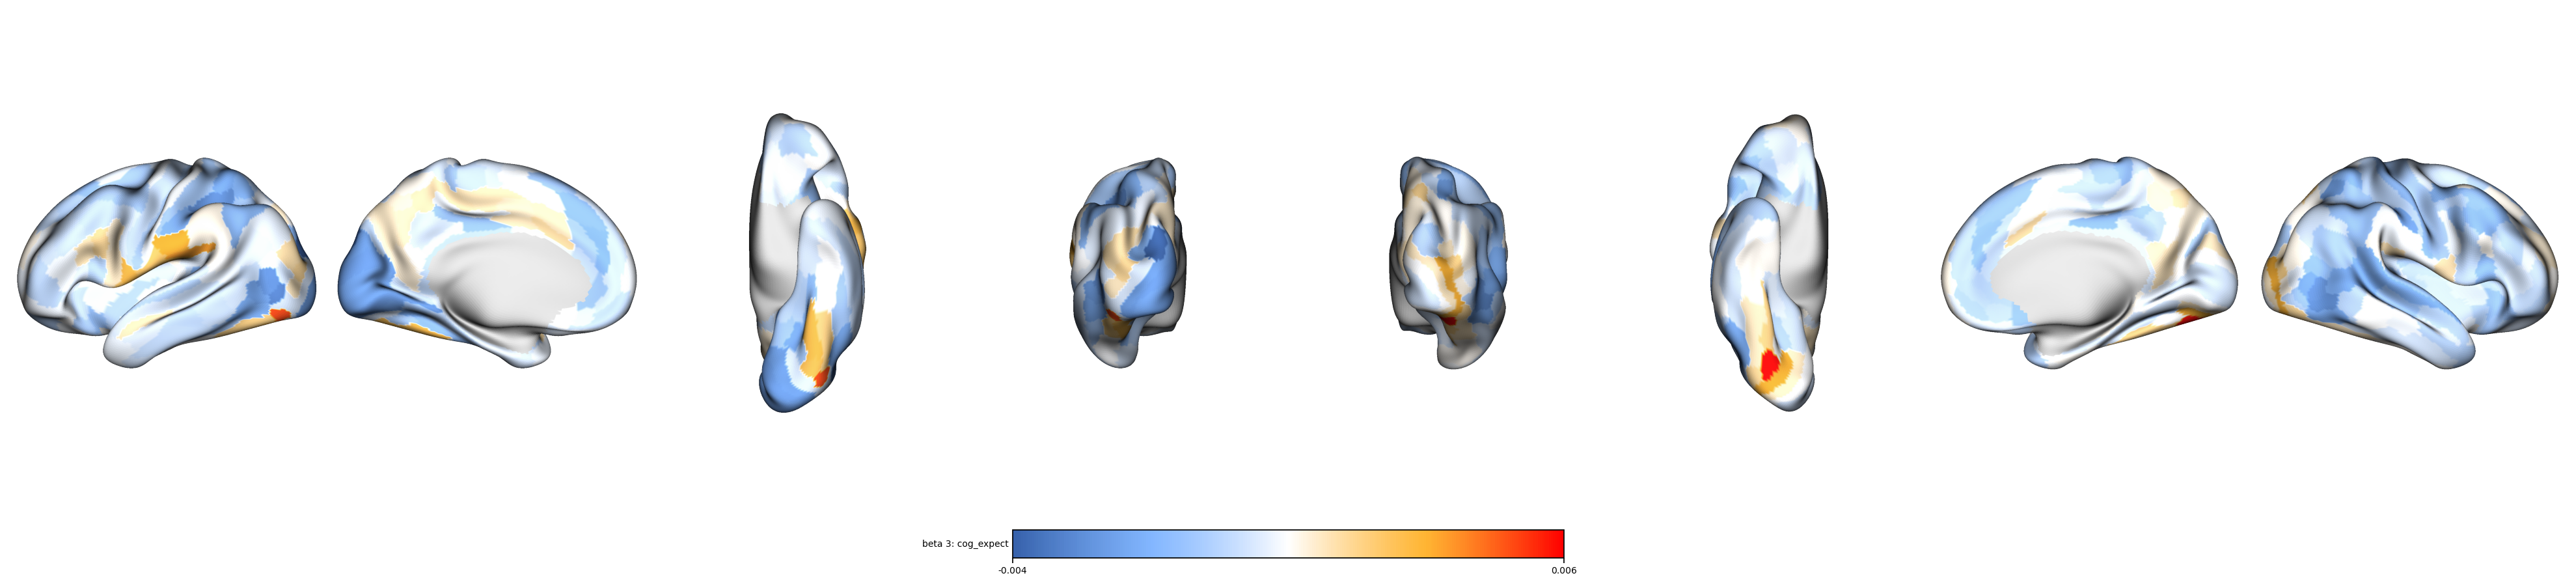

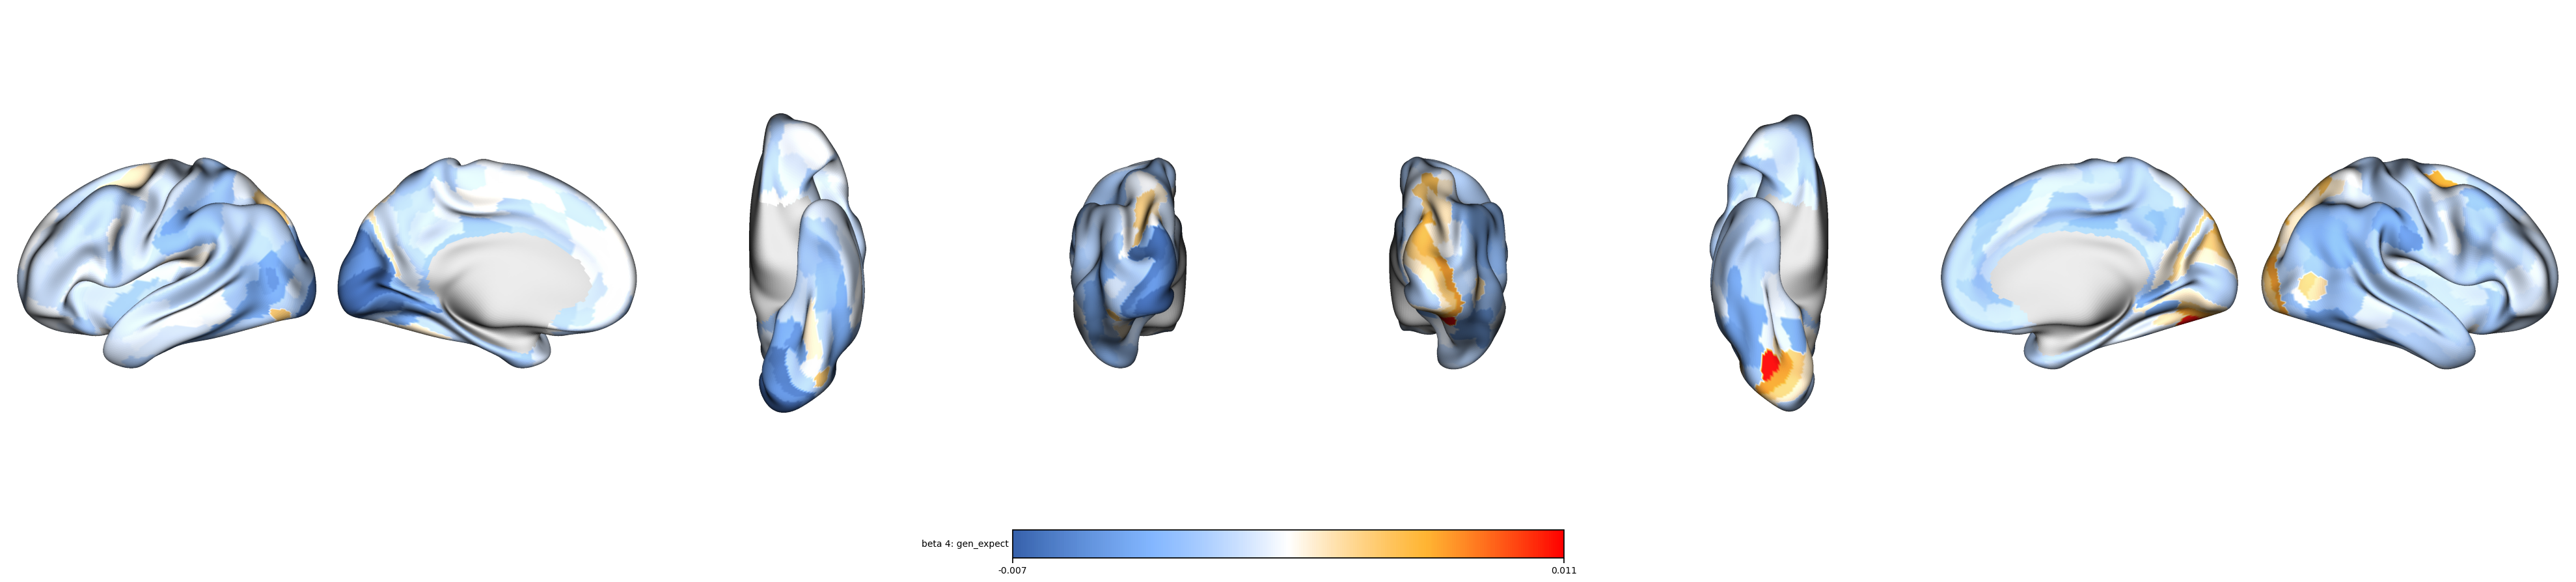

In [62]:
avg_beta_mat = np.mean(np.stack(beta_per_fold), axis=0)
factor_name = ['pain_expect', 'vic_expect', 'cog_expect', 'gen_expect']
# color_range = [(0.95, 1.05),(-0.04, 0.075),(2.5, 9.5), (3,9), (.55, 1.15) ]
for beta_ind in range(len(factor_name)):
    beta_i = mean_coef[:360, beta_ind]
    beta_inv = HCPparc.inverse_transform(beta_i)
    # plt.hist(beta)
    fig = plot_brain_surfaces(image=beta_inv, cbar_label=f'beta {beta_ind+1}: {factor_name[beta_ind]}', cmap=cmap)#color_range[beta_ind])
    plt.show()

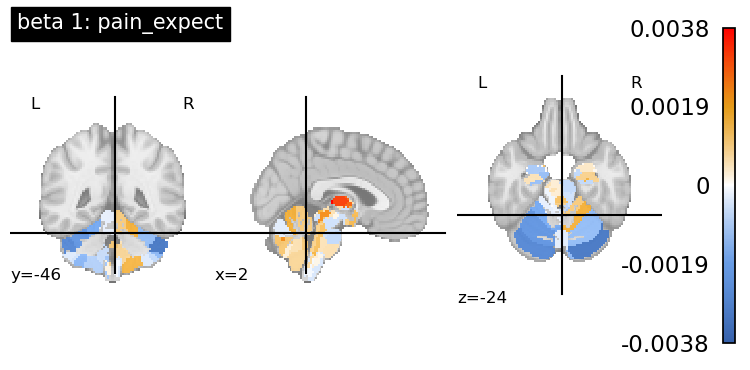

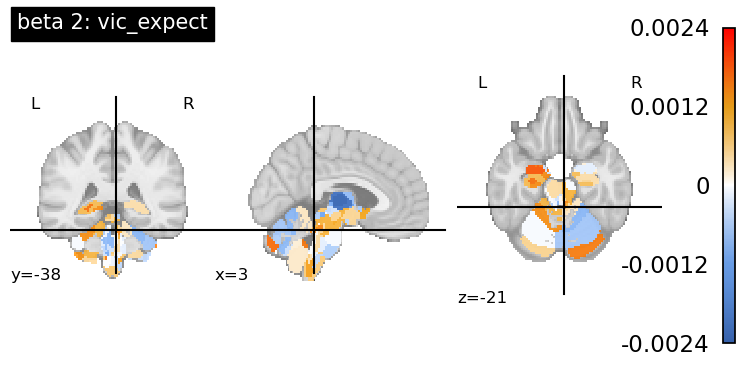

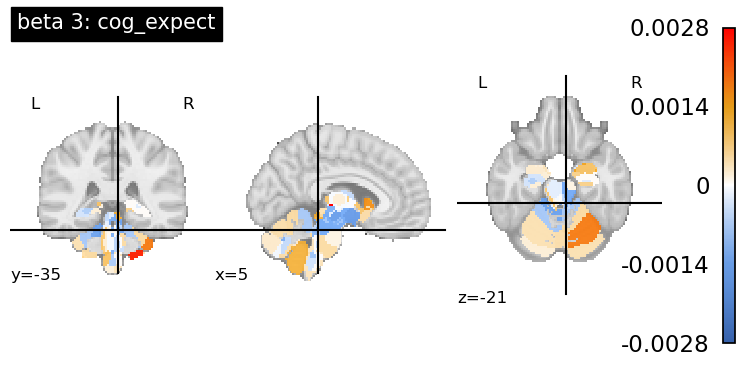

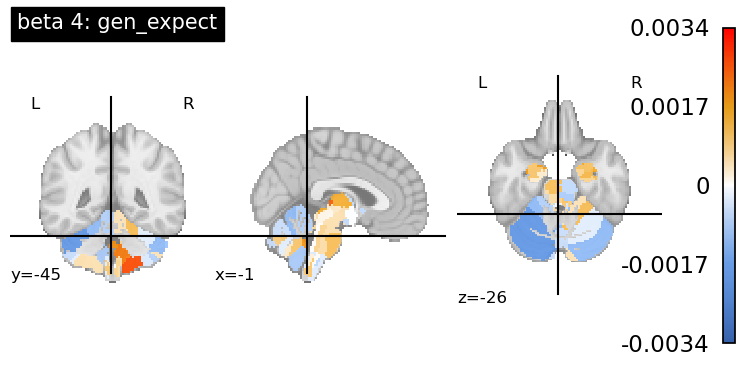

In [64]:
avg_beta_mat = np.mean(np.stack(beta_per_fold), axis=0)
factor_name = ['pain_expect', 'vic_expect', 'cog_expect', 'gen_expect']

for beta_ind in range(len(factor_name)):
    beta_i = mean_coef[360:, beta_ind]
    beta_inv = subcortexparc.inverse_transform(beta_i)

    plotting.plot_stat_map(beta_inv, title=f'beta {beta_ind+1}: {factor_name[beta_ind]}', cmap=cmap)

    plt.show()

## 2-2. predict score

In [65]:
Youtcome = np.vstack(y_preds)
Ytest = np.vstack(y_tests)
flattened_array = np.concatenate(test_ids)
trial_indices = np.concatenate(test_indices)
print(f"* Y outcome shape : {Youtcome.shape}")
print(f"* Y outcome column 1 - Predicted Pain rating: {Youtcome[:, 0]}")
# check if the number of test ids match the trial indices

for testsubid in np.unique(flattened_array):
    subid = df_mapping.loc[df_mapping['group_id'] == testsubid, 'bids_id'].iloc[0]
    mask_trialidx = flattened_array == testsubid
    len(beh_dropna.loc[beh_dropna['sub'] == subid].index) == np.sum(mask_trialidx)
    print(f"testsubid  {testsubid} is BIDS {subid}\nthe length of trial from test data {np.sum(mask_trialidx)} matches trial length of BIDS {len(beh_dropna.loc[beh_dropna['sub'] == subid].index)}")



* Y outcome shape : (16055, 4)
* Y outcome column 1 - Predicted Pain rating: [0.27201737 0.27112494 0.16789022 ... 0.31840654 0.32756498 0.21647863]
testsubid  1 is BIDS sub-0002
the length of trial from test data 42 matches trial length of BIDS 42
testsubid  2 is BIDS sub-0005
the length of trial from test data 142 matches trial length of BIDS 142
testsubid  3 is BIDS sub-0013
the length of trial from test data 139 matches trial length of BIDS 139
testsubid  4 is BIDS sub-0014
the length of trial from test data 136 matches trial length of BIDS 136
testsubid  5 is BIDS sub-0015
the length of trial from test data 55 matches trial length of BIDS 55
testsubid  6 is BIDS sub-0016
the length of trial from test data 140 matches trial length of BIDS 140
testsubid  7 is BIDS sub-0017
the length of trial from test data 110 matches trial length of BIDS 110
testsubid  8 is BIDS sub-0018
the length of trial from test data 142 matches trial length of BIDS 142
testsubid  9 is BIDS sub-0019
the lengt

In [53]:
beh_sorted = beh_dropna.iloc[trial_indices].copy()
regressor_name = ['pred_pain_expect_cueepoch', 'pred_vicarious_expect_cueepoch',
                   'pred_cognitive_expect_cueepoch', 'pred_general_expect_cueepoch']
for i, regressor in enumerate(regressor_name):
    beh_sorted.loc[:, regressor] = Youtcome[:,i]
# beh_sorted.head()

## quitiles with error bars


In [66]:
sns.set_context("notebook", font_scale=1.5)  # Increase the font scale; adjust as needed

beh_sorted = beh_dropna.iloc[trial_indices].copy()
regressor_name = ['pred_pain_expect_cueepoch', 'pred_vicarious_expect_cueepoch',
                   'pred_cognitive_expect_cueepoch', 'pred_general_expect_cueepoch']
for i, regressor in enumerate(regressor_name):
    beh_sorted.loc[:, regressor] = Youtcome[:,i]


beh_sorted['expectrating_quintile'] = beh_sorted.groupby(['sub', 'runtype'])['rescaled_expectrating'].transform(
    lambda x: pd.qcut(x, 5, labels=range(1,6))
)

# Assuming sub_means contains 'expectrating', 'expectrating_quintile', and 'sub' columns
subject_stats = beh_sorted.groupby(['sub','runtype', 'expectrating_quintile'])['rescaled_expectrating'].agg(['mean', 'sem']).reset_index()
# Aggregate the subject-wise mean and SEM across subjects within each quintile
quintile_stats = subject_stats.groupby(['runtype','expectrating_quintile']).agg({
    'mean': ['mean'],
    'sem': ['mean']  # Aggregate SEMs too if you plan to visualize within-subject variability
}).reset_index()
quintile_stats.columns = ['_'.join(col).strip() for col in quintile_stats.columns.values]
quintile_stats.rename(columns={'mean_mean': 'observed_quintile', 'sem_mean': 'observed_sem'}, inplace=True)


subject_P_stats = beh_sorted.groupby(['sub','runtype', 'expectrating_quintile'])['pred_pain_expect_cueepoch'].agg(['mean', 'sem']).reset_index()
# Aggregate the subject-wise mean and SEM across subjects within each quintile
quintile_P_stats = subject_P_stats.groupby(['runtype','expectrating_quintile']).agg({
    'mean': ['mean'],
    'sem': ['mean']  # Aggregate SEMs too if you plan to visualize within-subject variability
}).reset_index()
quintile_P_stats.columns = ['_'.join(col).strip() for col in quintile_P_stats.columns.values]
quintile_P_stats.rename(columns={'mean_mean': 'pred_pain_quintile', 'sem_mean': 'pred_pain_sem'}, inplace=True)



subject_V_stats = beh_sorted.groupby(['sub','runtype', 'expectrating_quintile'])['pred_vicarious_expect_cueepoch'].agg(['mean', 'sem']).reset_index()
# Aggregate the subject-wise mean and SEM across subjects within each quintile
quintile_V_stats = subject_V_stats.groupby(['runtype','expectrating_quintile']).agg({
    'mean': ['mean'],
    'sem': ['mean']  # Aggregate SEMs too if you plan to visualize within-subject variability
}).reset_index()
quintile_V_stats.columns = ['_'.join(col).strip() for col in quintile_V_stats.columns.values]
quintile_V_stats.rename(columns={'mean_mean': 'pred_vic_quintile', 'sem_mean': 'pred_vic_sem'}, inplace=True)



subject_C_stats = beh_sorted.groupby(['sub','runtype', 'expectrating_quintile'])['pred_cognitive_expect_cueepoch'].agg(['mean', 'sem']).reset_index()
# Aggregate the subject-wise mean and SEM across subjects within each quintile
quintile_C_stats = subject_C_stats.groupby(['runtype','expectrating_quintile']).agg({
    'mean': ['mean'],
    'sem': ['mean']  # Aggregate SEMs too if you plan to visualize within-subject variability
}).reset_index()
quintile_C_stats.columns = ['_'.join(col).strip() for col in quintile_C_stats.columns.values]
quintile_C_stats.rename(columns={'mean_mean': 'pred_cog_quintile', 'sem_mean': 'pred_cog_sem'}, inplace=True)



subject_G_stats = beh_sorted.groupby(['sub','runtype', 'expectrating_quintile'])['pred_general_expect_cueepoch'].agg(['mean', 'sem']).reset_index()
# Aggregate the subject-wise mean and SEM across subjects within each quintile
quintile_G_stats = subject_G_stats.groupby(['runtype','expectrating_quintile']).agg({
    'mean': ['mean'],
    'sem': ['mean']  # Aggregate SEMs too if you plan to visualize within-subject variability
}).reset_index()
quintile_G_stats.columns = ['_'.join(col).strip() for col in quintile_G_stats.columns.values]
quintile_G_stats.rename(columns={'mean_mean': 'pred_gen_quintile', 'sem_mean': 'pred_gen_sem'}, inplace=True)


# Example for merging two dataframes, repeat for others
merged_df = pd.merge(quintile_stats, quintile_P_stats, on=['runtype_', 'expectrating_quintile_'], suffixes=('', '_P'))

# Continue merging with other DataFrames
merged_df = pd.merge(merged_df, quintile_V_stats, on=['runtype_', 'expectrating_quintile_'], suffixes=('', '_V'))
merged_df = pd.merge(merged_df, quintile_C_stats, on=['runtype_', 'expectrating_quintile_'], suffixes=('', '_C'))
merged_df = pd.merge(merged_df, quintile_G_stats, on=['runtype_', 'expectrating_quintile_'], suffixes=('', '_G'))




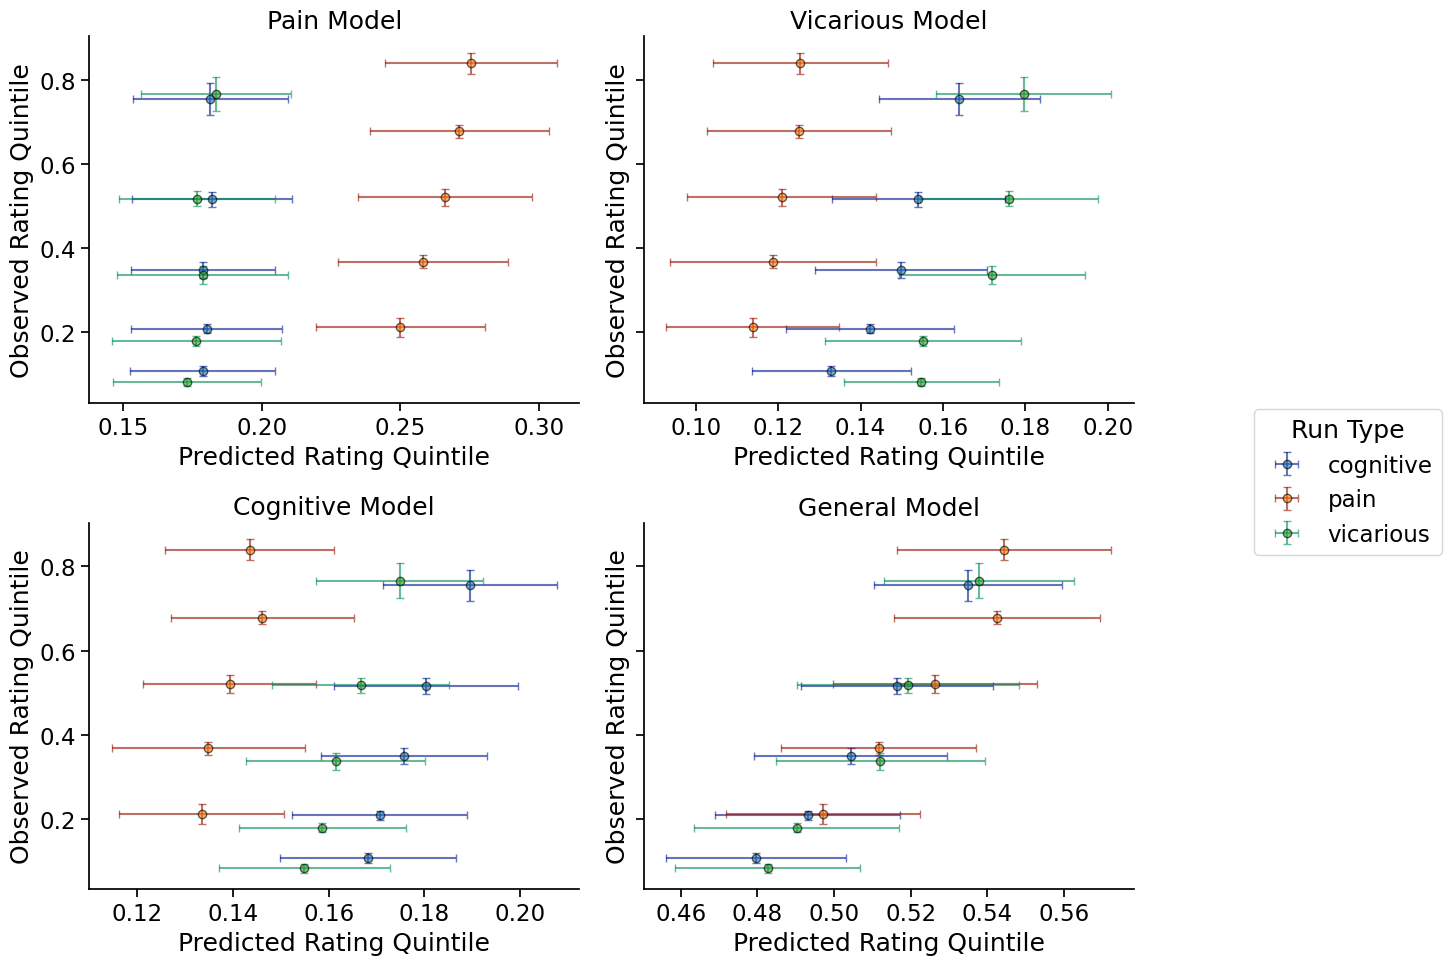

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame containing all the columns mentioned
sns.set_context("notebook", font_scale=1.5)

# Prepare the plot settings
model_vars = [
    ('pred_pain_quintile', 'pred_pain_sem', 'observed_quintile', 'observed_sem', 'pain'),
    ('pred_vic_quintile', 'pred_vic_sem', 'observed_quintile', 'observed_sem', 'vicarious'),
    ('pred_cog_quintile', 'pred_cog_sem', 'observed_quintile', 'observed_sem', 'cognitive'),
    ('pred_gen_quintile', 'pred_gen_sem', 'observed_quintile', 'observed_sem', 'general'),
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=False, sharey=True)
axes = axes.flatten()

# Obtain a unique list of run types
run_types = merged_df['runtype_'].unique()

# Generate a custom palette for runtype
# This will create a distinct color for each runtype
# custom_palette = sns.color_palette("viridis", len(run_types))
palette_dict = {
    'pain':'#941100',
    'vicarious':'#008F51',
    'cognitive':'#011891'
}
#dict(zip(run_types, custom_palette))

fallback_color = '#00000'
for i, (pred_q, pred_sem, obs_q, obs_sem, title) in enumerate(model_vars):
    ax = axes[i]
    
    # Iterate through each runtype to plot them with different colors
    for runtype in run_types:
        subset = merged_df[merged_df['runtype_'] == runtype]
        # color = palette_dict.get(runtype, '#000000')
        color = palette_dict.get(runtype, fallback_color) 
        ax.errorbar(subset[pred_q], subset[obs_q], 
                    xerr=subset[pred_sem], yerr=subset[obs_sem],
                    fmt='o', ecolor=color, capsize=3, label=runtype, alpha=0.6, mec='black')
    # palette_dict[runtype]
    ax.set_title(f'{title.capitalize()} Model')
    ax.set_xlabel('Predicted Rating Quintile')
    ax.set_ylabel('Observed Rating Quintile')
    # ax.set_xlim(0,100)
    # ax.set_ylim(0,100)
# Adjust legend placement outside of the plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Run Type', bbox_to_anchor=(1.05, 0.5), loc='center left')

sns.despine()
plt.tight_layout()
plt.show()


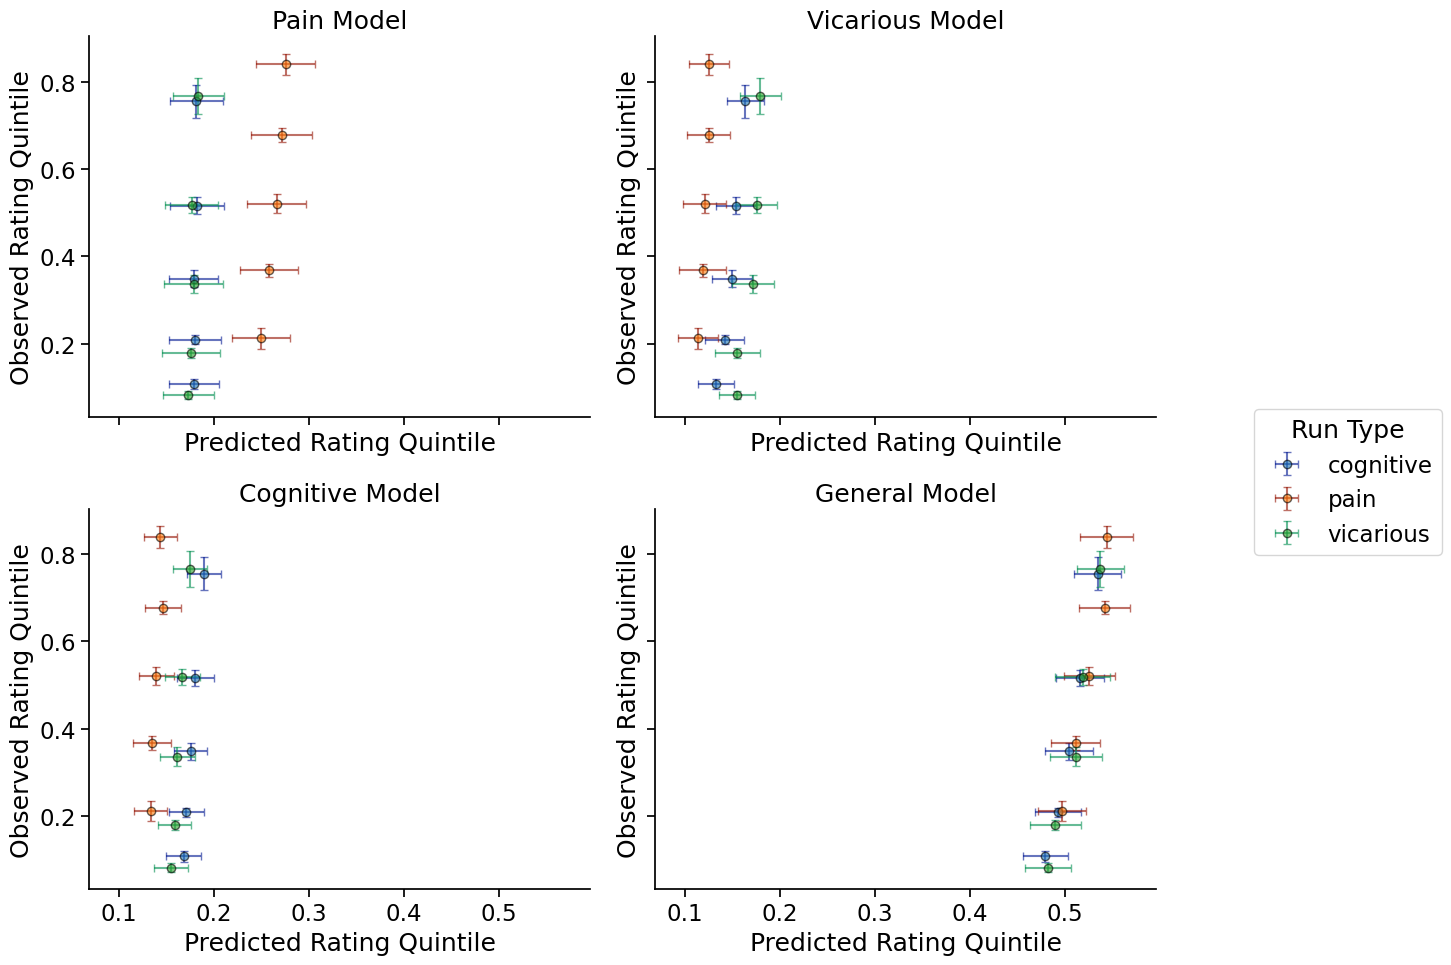

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame containing all the columns mentioned
sns.set_context("notebook", font_scale=1.5)

# Prepare the plot settings
model_vars = [
    ('pred_pain_quintile', 'pred_pain_sem', 'observed_quintile', 'observed_sem', 'pain'),
    ('pred_vic_quintile', 'pred_vic_sem', 'observed_quintile', 'observed_sem', 'vicarious'),
    ('pred_cog_quintile', 'pred_cog_sem', 'observed_quintile', 'observed_sem', 'cognitive'),
    ('pred_gen_quintile', 'pred_gen_sem', 'observed_quintile', 'observed_sem', 'general'),
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Obtain a unique list of run types
run_types = merged_df['runtype_'].unique()

# Generate a custom palette for runtype
# This will create a distinct color for each runtype
# custom_palette = sns.color_palette("viridis", len(run_types))
palette_dict = {
    'pain':'#941100',
    'vicarious':'#008F51',
    'cognitive':'#011891'
}
#dict(zip(run_types, custom_palette))

fallback_color = '#00000'
for i, (pred_q, pred_sem, obs_q, obs_sem, title) in enumerate(model_vars):
    ax = axes[i]
    
    # Iterate through each runtype to plot them with different colors
    for runtype in run_types:
        subset = merged_df[merged_df['runtype_'] == runtype]
        # color = palette_dict.get(runtype, '#000000')
        color = palette_dict.get(runtype, fallback_color) 
        ax.errorbar(subset[pred_q], subset[obs_q], 
                    xerr=subset[pred_sem], yerr=subset[obs_sem],
                    fmt='o', ecolor=color, capsize=3, label=runtype, alpha=0.6, mec='black')
    # palette_dict[runtype]
    ax.set_title(f'{title.capitalize()} Model')
    ax.set_xlabel('Predicted Rating Quintile')
    ax.set_ylabel('Observed Rating Quintile')
    # ax.set_xlim(0,100)
    # ax.set_ylim(0,100)
# Adjust legend placement outside of the plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Run Type', bbox_to_anchor=(1.05, 0.5), loc='center left')

sns.despine()
plt.tight_layout()
plt.show()


In [195]:
beh_sorted.to_csv(join(main_dir, 'analysis', 'fmri', 'nilearn', 'pls', 'pls_epoch-cue_model-expectPE_regressor-expect.tsv'), sep='\t', index=False)

### 2-3. predict scores based on cue type

# loadings

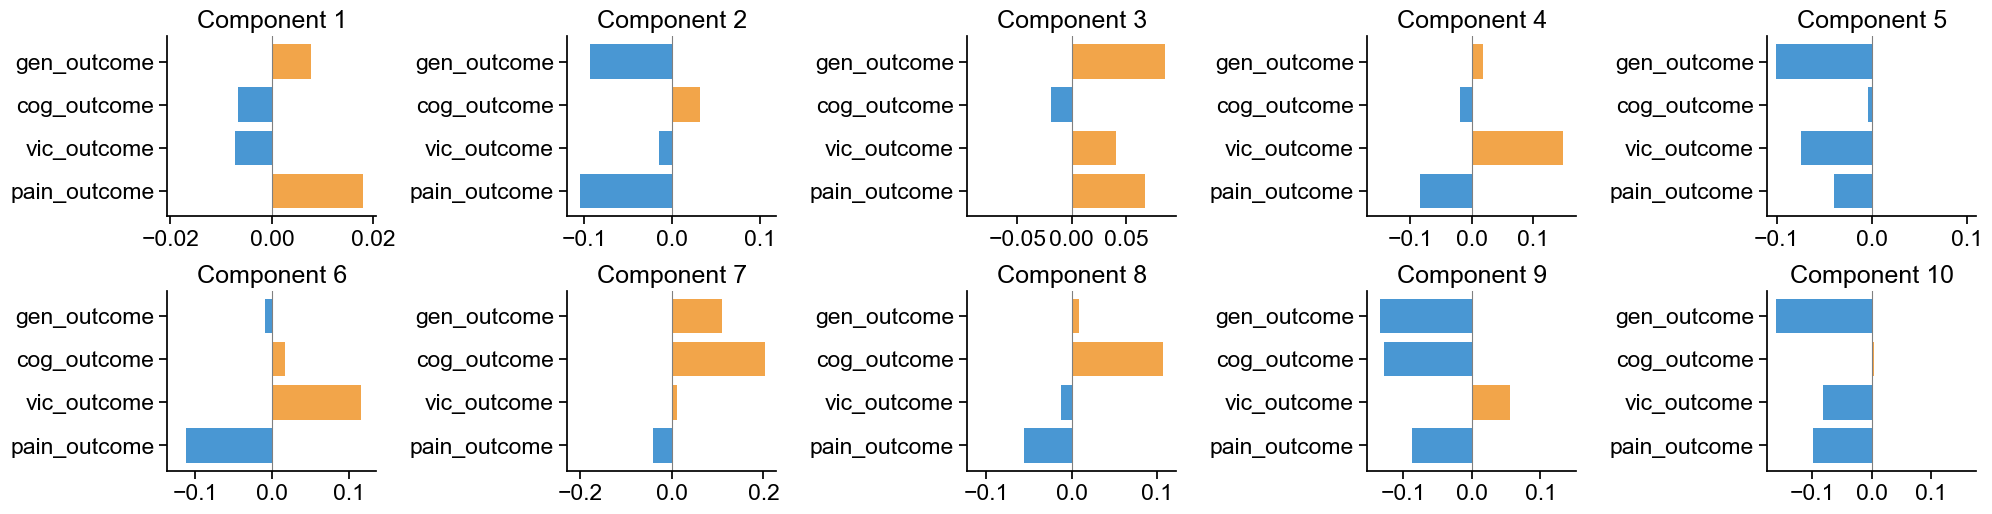

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Set font properties globally for all plots
matplotlib.rcParams['font.size'] = 10  # You can change the size here
matplotlib.rcParams['font.family'] = 'sans-serif'  # Change the font family if needed
matplotlib.rcParams['font.sans-serif'] = ['Arial']  # Or any other sans-serif font

# Assuming 'pls_model' is your fitted PLS model and 'Y' is your Y matrix with columns
y_loadings = pls_subj.y_loadings_
column_names =['pain_outcome', 'vic_outcome', 'cog_outcome', 'gen_outcome'] #["Cue contrasts", "Stim. intensity contrasts", "Expectation rating", "Outcome rating", "NPS (pos)"]

# We want to create a 4x5 grid of plots, one for each component
n_rows = 4
n_cols = 5
n_components = y_loadings.shape[1]  # This should be 20 as per your model

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))  # Adjust the figsize accordingly

# Define the bar width
bar_width = 0.8

for i in range(n_components):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    loadings = y_loadings[:, i]
    
    # Color bars based on their value
    colors = ['#4997D3' if x < 0 else '#F2A54A' for x in loadings]
    # Set the y-ticks to match the number of column names
    ax.set_yticks(np.arange(len(column_names)))
    # Create a horizontal bar plot with colors and narrow bars
    bars = ax.barh(column_names, loadings, color=colors, height=bar_width)
    
    ax.set_title(f'Component {i+1}')
    ax.set_yticklabels(column_names, rotation=0)
    ax.axvline(0, color='grey', linewidth=0.8)  # Add a vertical line at x=0 for the zero point

    # Set the x-axis limits to be symmetrical based on the largest magnitude loading
    max_loading = np.max(np.abs(loadings))
    se = np.std(loadings)/len(loadings)
    ax.set_xlim([-max_loading-se, max_loading+se])
    
    # Optional: Remove the axes for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)  # Add the bottom spine for the horizontal X axis
    ax.spines['left'].set_visible(True)  # Retain the left spine to have a reference line for zero

# Hide any unused subplots if the number of components is less than the number of subplot slots
for i in range(n_components, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row][col])

fig.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()